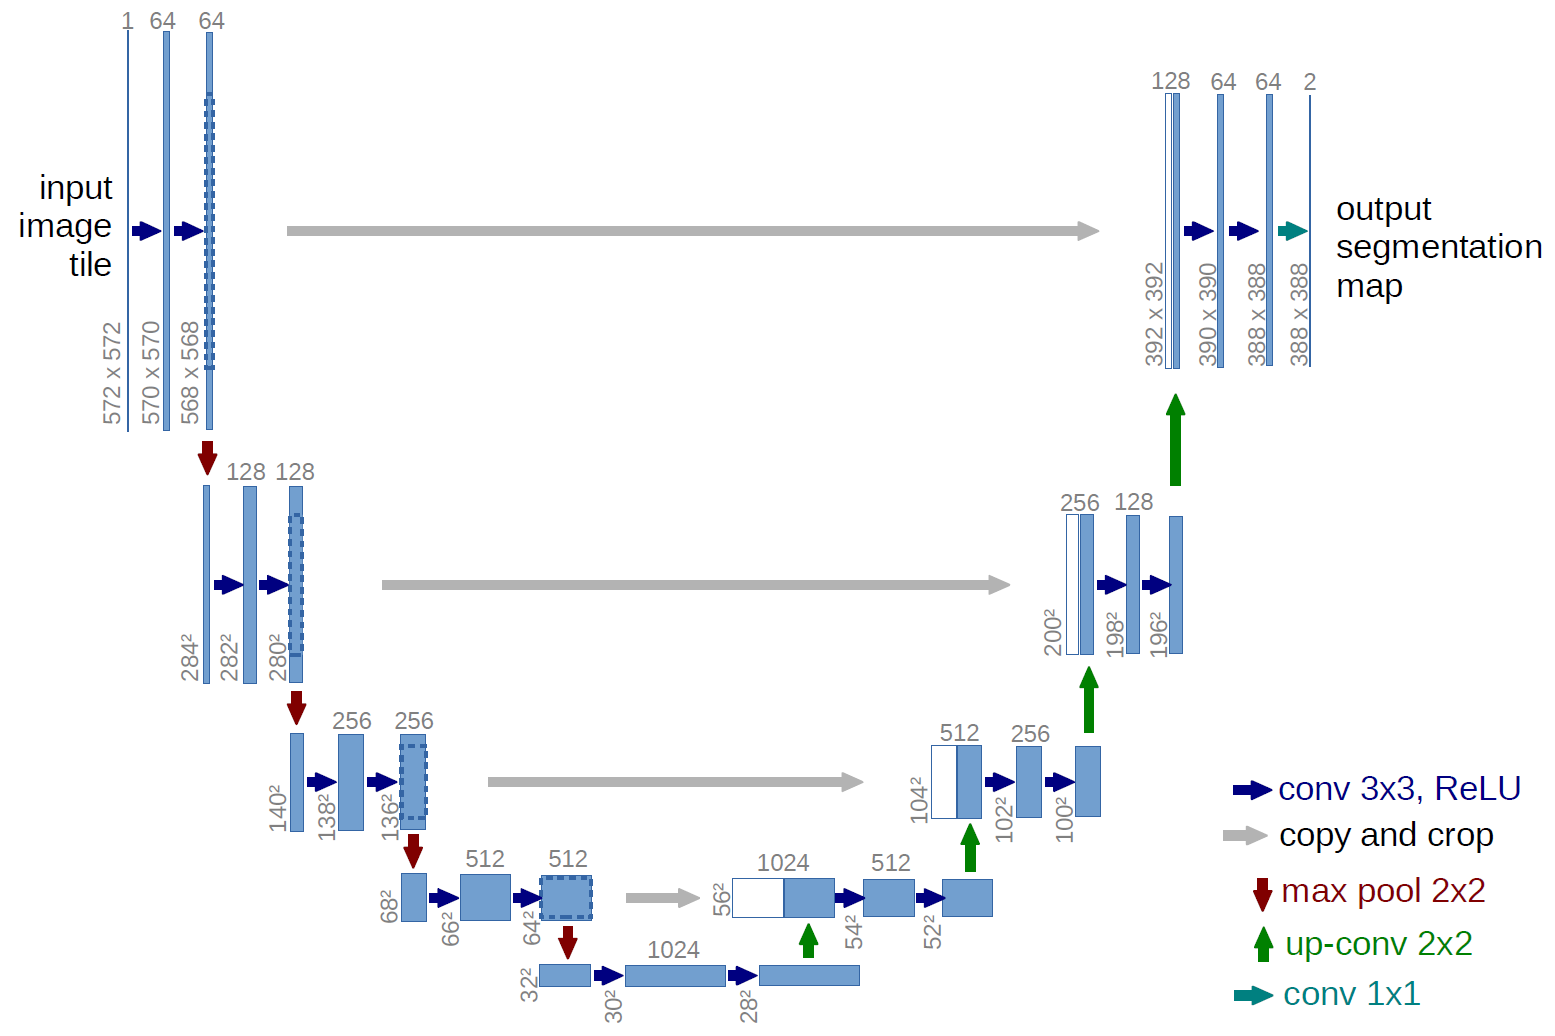

In [20]:
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 49.9MB/s]


In [77]:
class Unet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 1-й блок
    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # середина
    self.conv4 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
    self.conv5 = nn.ConvTranspose2d(16, 8, kernel_size=1, stride=1)# 2-й блок
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # слой для задачи классификации
    self.conv6 = nn.Linear(8,10) # должен быть conv2d но так как задача классификации пишем linear
    self.relu = nn.ReLU()
  def forward(self,x):
    conv1 = self.relu(self.conv1(x))
    conv2 = self.relu(self.conv2(conv1))
    pool1 = (self.pool1(conv2))
    conv3 = self.relu(self.conv3(pool1))
    conv4 = self.relu(self.conv4(conv3))
    conv4 = conv4 + conv2
    conv5 = self.relu(self.conv5(conv4))
    conv5 = conv5 + conv1
    x = self.avgpool(conv5)
    x = x.view(x.size(0), -1)
    conv6 = self.relu(self.conv6(x))

    return conv6

In [29]:
criterion = nn.CrossEntropyLoss()
model = Unet()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
device = 'cpu'

In [78]:
model = Unet()
x = torch.randn(1, 3, 64, 64)  # dummy input: batch=1, channels=3, 64x64 image
y = model(x)
print(y.shape)  # должно выдать torch.Size([1, 1, H, W]) — точные размеры зависят от паддингов


torch.Size([1, 10])


In [81]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}')

    print('Finished Training')

train_model(model, criterion, optimizer, num_epochs=3)

Epoch [1/3], Loss: 2.3058
Epoch [2/3], Loss: 2.3058
Epoch [3/3], Loss: 2.3058
Finished Training


In [82]:
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:02<00:00, 77.5MB/s]


In [85]:
classes = trainset.classes

In [83]:
def evaluate_model(model):
    model.eval()  # Устанавливаем модель в режим оценки
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

evaluate_model(model)


Accuracy on the test set: 0.81%


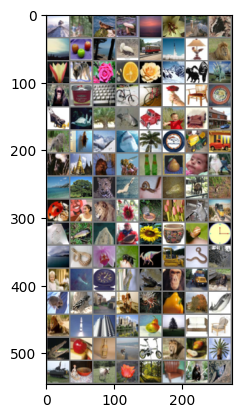

IndexError: list index out of range

In [86]:

def imshow(img):
    img = img / 2 + 0.5  # Нормализация обратно
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Выводим несколько тестовых изображений с предсказаниями
dataiter = iter(testloader)
images, labels = next(dataiter)

# Получаем предсказания модели
outputs = model(images.to(device))
_, predicted = torch.max(outputs.data, 1)

# Визуализируем изображения и их предсказания
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))
print('Predicted: ', ' '.join(f'{classes[predicted[j].item()]}' for j in range(4)))